## Project Requirements
Analyze and segment customer data from a retail dataset using K-means clustering to identify distinct customer groups based on purchasing patterns, and visualize the findings with clear explanations and business implications.

## Load and Inspect Data

Load the retail dataset into a pandas DataFrame and perform an initial inspection to understand its structure, data types, and identify any immediate issues like missing values or inconsistencies.


In [1]:
import pandas as pd

# Load the dataset
df = pd.read_csv('/content/drive/MyDrive/LinkedInProjects/DataMining/Dataset/Mall_Customers.csv')

# Display the first 5 rows
print("First 5 rows of the DataFrame:")
print(df.head())

# Print a summary of the DataFrame
print("\nDataFrame Info:")
df.info()

# Check for missing values
print("\nMissing values in each column:")
print(df.isnull().sum())

First 5 rows of the DataFrame:
   CustomerID  Gender  Age  Annual Income (k$)  Spending Score (1-100)
0           1    Male   19                  15                      39
1           2    Male   21                  15                      81
2           3  Female   20                  16                       6
3           4  Female   23                  16                      77
4           5  Female   31                  17                      40

DataFrame Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200 entries, 0 to 199
Data columns (total 5 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   CustomerID              200 non-null    int64 
 1   Gender                  200 non-null    object
 2   Age                     200 non-null    int64 
 3   Annual Income (k$)      200 non-null    int64 
 4   Spending Score (1-100)  200 non-null    int64 
dtypes: int64(4), object(1)
memory usage: 7.9+ KB

Missing

## Clean and Preprocess Data

Handle missing values, remove or transform outliers, and preprocess the data by encoding categorical variables and scaling numerical features to prepare it for clustering.


In [2]:
from sklearn.preprocessing import StandardScaler

# 1. Create a copy of the original DataFrame
df_processed = df.copy()

# 2. Drop CustomerID
df_processed = df_processed.drop('CustomerID', axis=1)

# 3. Encode Gender
df_processed = pd.get_dummies(df_processed, columns=['Gender'], drop_first=True)

# Rename the encoded column for clarity if 'Male' is the remaining one
# Note: pd.get_dummies automatically creates 'Gender_Male' if drop_first=True for 'Male' category
# and 'Gender_Female' if there were more than two categories or drop_first=False
# For binary 'Gender', with drop_first=True, it will create one column, typically 'Gender_Male' if Male is the second category alphabetically or by order of appearance.
# Let's verify the column name for 'Gender' after one-hot encoding, as it will likely be 'Gender_Male' if Female was dropped.
if 'Gender_Male' in df_processed.columns:
    print("Gender column encoded as 'Gender_Male'.")
else:
    print("Gender column encoded differently. Check column names.")

# 4. Identify numerical features for scaling
numerical_features = ['Age', 'Annual Income (k$)', 'Spending Score (1-100)']

# 5. Scale numerical features
scaler = StandardScaler()
df_processed[numerical_features] = scaler.fit_transform(df_processed[numerical_features])

# 6. Display the first 5 rows and a summary of the df_processed DataFrame
print("\nFirst 5 rows of the processed DataFrame:")
print(df_processed.head())

print("\nInfo of the processed DataFrame:")
df_processed.info()

Gender column encoded as 'Gender_Male'.

First 5 rows of the processed DataFrame:
        Age  Annual Income (k$)  Spending Score (1-100)  Gender_Male
0 -1.424569           -1.738999               -0.434801         True
1 -1.281035           -1.738999                1.195704         True
2 -1.352802           -1.700830               -1.715913        False
3 -1.137502           -1.700830                1.040418        False
4 -0.563369           -1.662660               -0.395980        False

Info of the processed DataFrame:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200 entries, 0 to 199
Data columns (total 4 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   Age                     200 non-null    float64
 1   Annual Income (k$)      200 non-null    float64
 2   Spending Score (1-100)  200 non-null    float64
 3   Gender_Male             200 non-null    bool   
dtypes: bool(1), float64(3)
memory usage: 5.0 KB

## Perform Exploratory Data Analysis (EDA)

Conduct exploratory data analysis to understand purchasing patterns, customer demographics (if available), and other relevant features. Generate relevant visualizations like histograms, box plots, and correlation matrices to gain insights into the data's distribution and relationships.


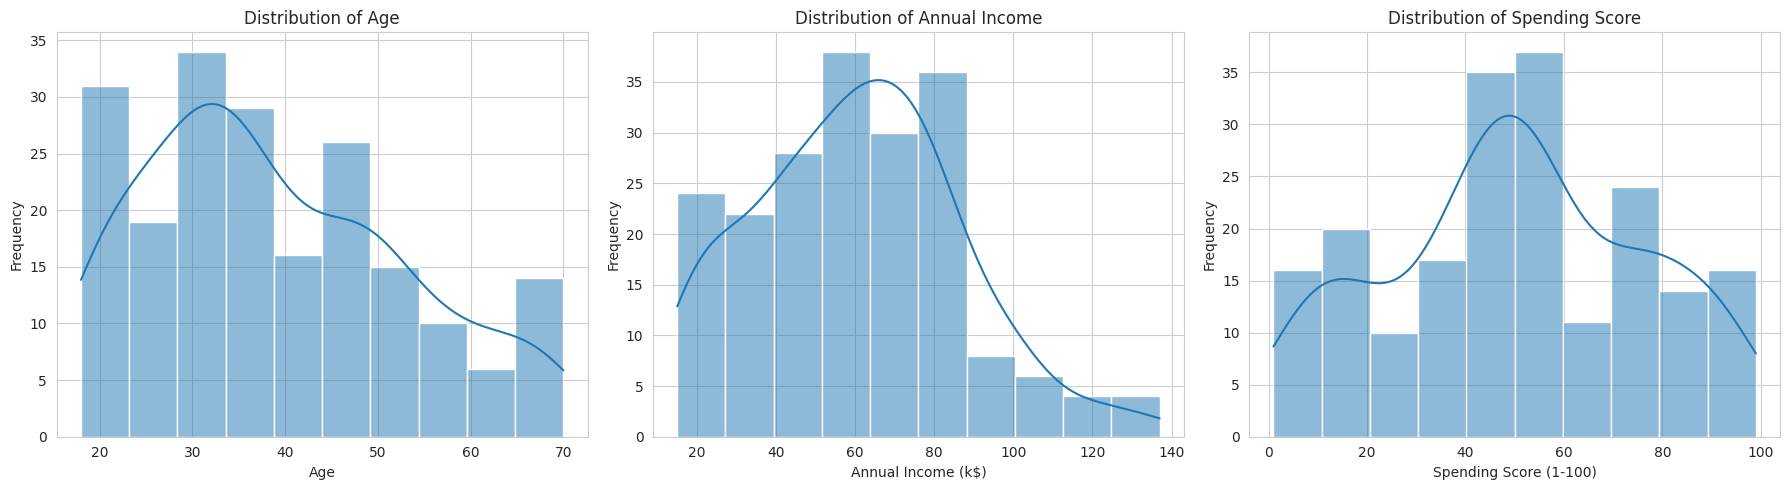

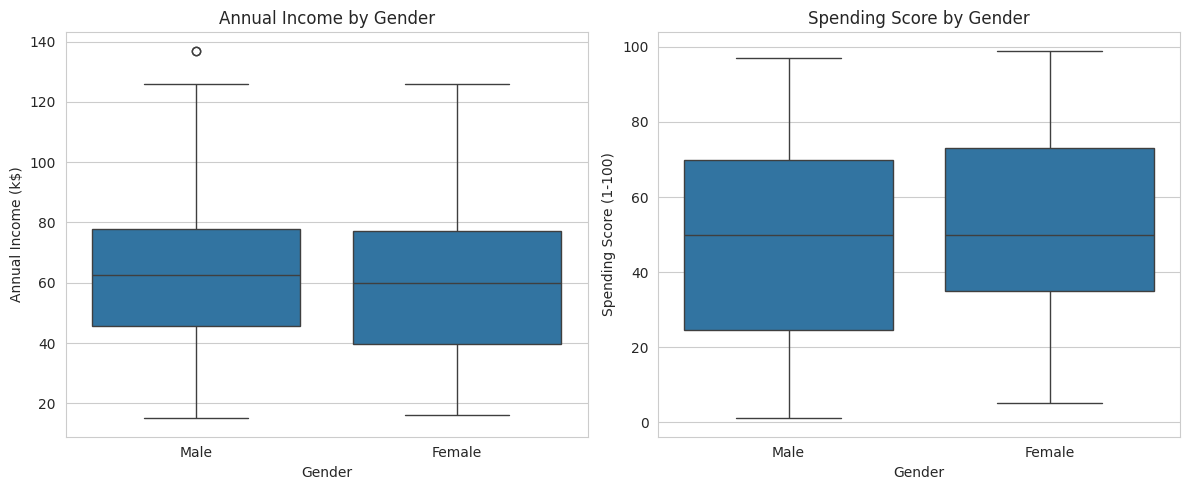

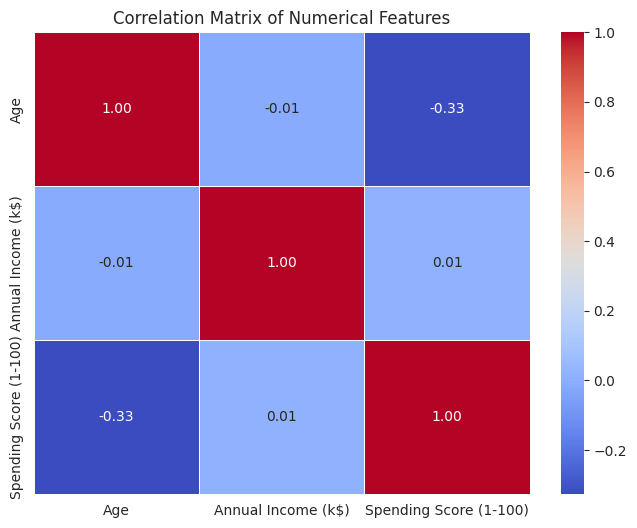

In [3]:
import matplotlib.pyplot as plt
import seaborn as sns

# 2. Set the aesthetic style of the plots
sns.set_style("whitegrid")

# 3. Histograms for numerical features
plt.figure(figsize=(18, 5))

plt.subplot(1, 3, 1)
sns.histplot(df['Age'], bins=10, kde=True)
plt.title('Distribution of Age')
plt.xlabel('Age')
plt.ylabel('Frequency')

plt.subplot(1, 3, 2)
sns.histplot(df['Annual Income (k$)'], bins=10, kde=True)
plt.title('Distribution of Annual Income')
plt.xlabel('Annual Income (k$)')
plt.ylabel('Frequency')

plt.subplot(1, 3, 3)
sns.histplot(df['Spending Score (1-100)'], bins=10, kde=True)
plt.title('Distribution of Spending Score')
plt.xlabel('Spending Score (1-100)')
plt.ylabel('Frequency')

plt.tight_layout()
plt.show()

# 4. Box plots comparing features across Gender
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
sns.boxplot(x='Gender', y='Annual Income (k$)', data=df)
plt.title('Annual Income by Gender')
plt.xlabel('Gender')
plt.ylabel('Annual Income (k$)')

plt.subplot(1, 2, 2)
sns.boxplot(x='Gender', y='Spending Score (1-100)', data=df)
plt.title('Spending Score by Gender')
plt.xlabel('Gender')
plt.ylabel('Spending Score (1-100)')

plt.tight_layout()
plt.show()

# 5. Calculate the correlation matrix for numerical columns
numerical_cols = ['Age', 'Annual Income (k$)', 'Spending Score (1-100)']
correlation_matrix = df[numerical_cols].corr()

# 6. Create a heatmap to visualize the correlation matrix
plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=.5)
plt.title('Correlation Matrix of Numerical Features')
plt.show()


## Determine Optimal Number of Clusters

Apply methods like the Elbow Method or Silhouette Score to determine the optimal number of clusters (k) for the K-means algorithm.


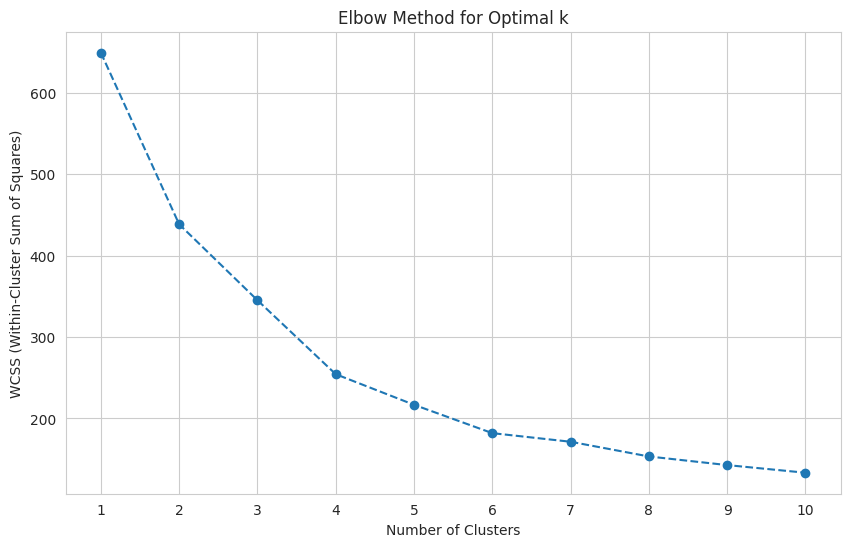

In [4]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

# 2. Create an empty list to store WCSS values
wcss = []

# 3. Iterate through a range of possible cluster numbers (e.g., from 1 to 10)
# We'll go up to 11 so that the range includes 10 clusters.
for i in range(1, 11):
    # 4a. Initialize a KMeans model
    kmeans = KMeans(n_clusters=i, init='k-means++', random_state=42, n_init='auto')

    # 4b. Fit the KMeans model to the preprocessed DataFrame
    kmeans.fit(df_processed)

    # 4c. Append the inertia_ (WCSS) to the wcss list
    wcss.append(kmeans.inertia_)

# 5. Plot the WCSS values against the number of clusters
plt.figure(figsize=(10, 6))
plt.plot(range(1, 11), wcss, marker='o', linestyle='--')
plt.title('Elbow Method for Optimal k')
plt.xlabel('Number of Clusters')
plt.ylabel('WCSS (Within-Cluster Sum of Squares)')
plt.xticks(range(1, 11))
plt.grid(True)

# 6. Display the plot
plt.show()

### Interpretation of the Elbow Method

Based on the generated Elbow Method plot, we observe the following:

*   **Sharp Decrease (k=1 to k=3/4):** The WCSS drops sharply as the number of clusters increases from 1 to 3 or 4. This indicates that adding these initial clusters significantly improves the clustering by reducing the total within-cluster variance.
*   **Elbow Point (around k=5):** After approximately 5 clusters, the rate of decrease in WCSS becomes much less pronounced. This point, often referred to as the 'elbow', suggests that adding more clusters beyond this point provides diminishing returns in terms of reducing WCSS, and the additional complexity might not be justified.

Therefore, considering the 'elbow point' in the plot, **5 is identified as the optimal number of clusters (k)** for the K-means algorithm in this dataset. This number strikes a good balance between minimizing within-cluster variance and keeping the model interpretable.

Now that the optimal number of clusters (k=5) has been determined using the Elbow Method, the next step is to apply the K-means algorithm with this value of k to segment the customer data.


In [5]:
from sklearn.cluster import KMeans

# 1. Define the optimal number of clusters (k) based on the Elbow Method interpretation
optimal_k = 5

# 2. Initialize the KMeans model with the optimal k
kmeans = KMeans(n_clusters=optimal_k, init='k-means++', random_state=42, n_init='auto')

# 3. Fit the KMeans model to the preprocessed DataFrame and get the cluster labels
clusters = kmeans.fit_predict(df_processed)

# 4. Add the cluster labels to the processed DataFrame
df_processed['Cluster'] = clusters

# 5. Display the first few rows of the DataFrame with the new 'Cluster' column
print("First 5 rows of the processed DataFrame with cluster labels:")
print(df_processed.head())

# 6. Display the count of observations in each cluster
print("\nCluster distribution:")
print(df_processed['Cluster'].value_counts())

First 5 rows of the processed DataFrame with cluster labels:
        Age  Annual Income (k$)  Spending Score (1-100)  Gender_Male  Cluster
0 -1.424569           -1.738999               -0.434801         True        2
1 -1.281035           -1.738999                1.195704         True        4
2 -1.352802           -1.700830               -1.715913        False        2
3 -1.137502           -1.700830                1.040418        False        4
4 -0.563369           -1.662660               -0.395980        False        2

Cluster distribution:
Cluster
0    58
2    47
1    39
3    34
4    22
Name: count, dtype: int64


## Visualize Customer Segments

Visualize the identified customer segments using appropriate plots (e.g., scatter plots of key features, bar charts showing segment characteristics). Ensure these plots are clearly labeled and include legends to differentiate segments.


First 5 rows of df_clusters:
    Age  Annual Income (k$)  Spending Score (1-100)  Gender  Cluster
0  19.0                15.0                    39.0    Male        2
1  21.0                15.0                    81.0    Male        4
2  20.0                16.0                     6.0  Female        2
3  23.0                16.0                    77.0  Female        4
4  31.0                17.0                    40.0  Female        2

DataFrame Info for df_clusters:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200 entries, 0 to 199
Data columns (total 5 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   Age                     200 non-null    float64
 1   Annual Income (k$)      200 non-null    float64
 2   Spending Score (1-100)  200 non-null    float64
 3   Gender                  200 non-null    object 
 4   Cluster                 200 non-null    int32  
dtypes: float64(3), int32(1), object(1)
memory us

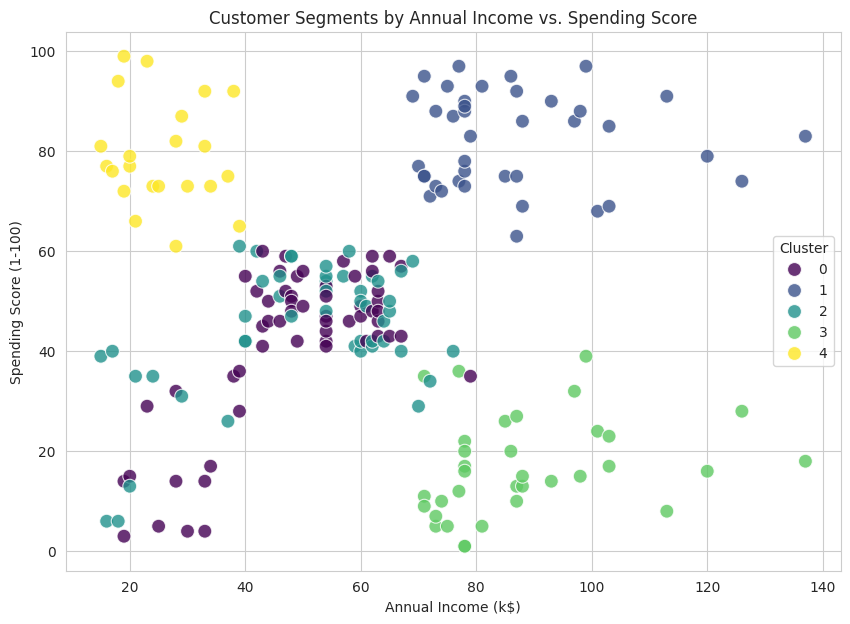

/tmp/ipython-input-4188466659.py:67: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Cluster', y='Age_Mean', data=cluster_summary, palette='viridis')
/tmp/ipython-input-4188466659.py:73: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Cluster', y='Annual_Income_Mean', data=cluster_summary, palette='viridis')
/tmp/ipython-input-4188466659.py:79: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Cluster', y='Spending_Score_Mean', data=cluster_summary, palette='viridis')


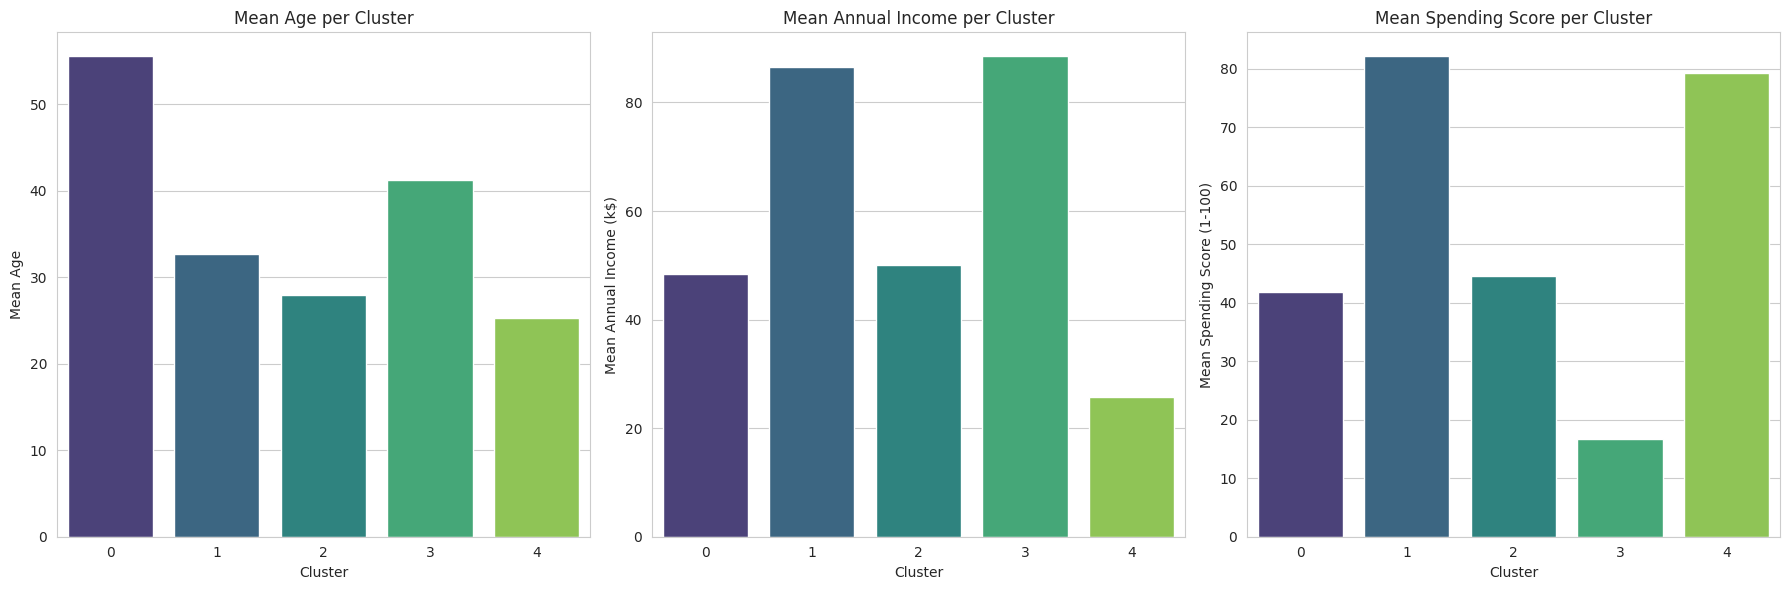

/tmp/ipython-input-4188466659.py:89: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Cluster', y='Male_Proportion', data=cluster_summary, palette='viridis')


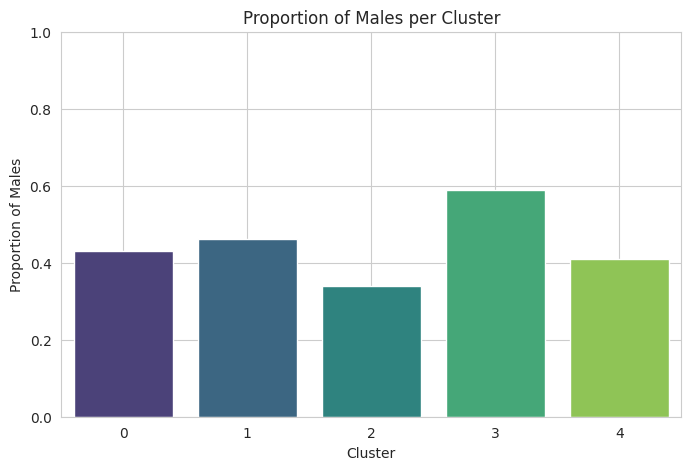

In [7]:
import numpy as np

# 1. Inverse transform the scaled numerical features
# First, isolate the scaled numerical features from df_processed
scaled_numerical_data = df_processed[numerical_features]
inverse_transformed_numerical_data = scaler.inverse_transform(scaled_numerical_data)

# Create a DataFrame from the inverse transformed data
df_original_numerical = pd.DataFrame(inverse_transformed_numerical_data, columns=numerical_features, index=df_processed.index)

# 2. Convert the 'Gender_Male' boolean column back to an interpretable 'Gender' column
# If Gender_Male is True, it's 'Male', otherwise 'Female'
df_original_gender = df_processed['Gender_Male'].apply(lambda x: 'Male' if x else 'Female').to_frame(name='Gender')

# 3. Create a new DataFrame, df_clusters, by combining the inverse-transformed numerical features,
# the original 'Gender' information, and the 'Cluster' assignments.
# Ensure all DataFrames have the same index before concatenating
df_clusters = pd.concat([df_original_numerical, df_original_gender, df_processed['Cluster']], axis=1)

# Display the first few rows of df_clusters to verify
print("First 5 rows of df_clusters:")
print(df_clusters.head())

print("\nDataFrame Info for df_clusters:")
df_clusters.info()

# 4. Calculate the mean of 'Age', 'Annual Income (k$)', 'Spending Score (1-100)', and gender distribution for each cluster
cluster_summary = df_clusters.groupby('Cluster').agg(
    Age_Mean=('Age', 'mean'),
    Annual_Income_Mean=('Annual Income (k$)', 'mean'),
    Spending_Score_Mean=('Spending Score (1-100)', 'mean'),
    Male_Proportion=('Gender', lambda x: (x == 'Male').mean())
).reset_index()

print("\nCluster Summary Statistics:")
print(cluster_summary)

# 5. Create a scatter plot of 'Annual Income (k$)' vs 'Spending Score (1-100)', colored by 'Cluster'.
plt.figure(figsize=(10, 7))
sns.scatterplot(
    x='Annual Income (k$)',
    y='Spending Score (1-100)',
    hue='Cluster',
    data=df_clusters,
    palette='viridis',
    s=100, # size of points
    alpha=0.8
)
plt.title('Customer Segments by Annual Income vs. Spending Score')
plt.xlabel('Annual Income (k$)')
plt.ylabel('Spending Score (1-100)')
plt.legend(title='Cluster')
plt.grid(True)
plt.show()

# 6. Generate bar plots for each feature across clusters

# Melting the cluster_summary for easier plotting of multiple bar charts
cluster_summary_melted = cluster_summary.melt(id_vars='Cluster',
                                              value_vars=['Age_Mean', 'Annual_Income_Mean', 'Spending_Score_Mean'],
                                              var_name='Feature',
                                              value_name='Mean_Value')

plt.figure(figsize=(18, 6))

plt.subplot(1, 3, 1)
sns.barplot(x='Cluster', y='Age_Mean', data=cluster_summary, palette='viridis')
plt.title('Mean Age per Cluster')
plt.xlabel('Cluster')
plt.ylabel('Mean Age')

plt.subplot(1, 3, 2)
sns.barplot(x='Cluster', y='Annual_Income_Mean', data=cluster_summary, palette='viridis')
plt.title('Mean Annual Income per Cluster')
plt.xlabel('Cluster')
plt.ylabel('Mean Annual Income (k$)')

plt.subplot(1, 3, 3)
sns.barplot(x='Cluster', y='Spending_Score_Mean', data=cluster_summary, palette='viridis')
plt.title('Mean Spending Score per Cluster')
plt.xlabel('Cluster')
plt.ylabel('Mean Spending Score (1-100)')

plt.tight_layout()
plt.show()

# Bar plot for Gender distribution
plt.figure(figsize=(8, 5))
sns.barplot(x='Cluster', y='Male_Proportion', data=cluster_summary, palette='viridis')
plt.title('Proportion of Males per Cluster')
plt.xlabel('Cluster')
plt.ylabel('Proportion of Males')
plt.ylim(0, 1) # Proportion is between 0 and 1
plt.grid(True)
plt.show()

### Data Analysis Key Findings

*   **Cluster 0: Mature Average Spenders**
    *   **Characteristics:** Highest average age ($\sim$55.5 years), average annual income ($\sim$48.5k\$), and average spending score ($\sim$41.8). Balanced gender distribution.
    *   **Implications:** Target with comfort, quality, and health-related products. Implement loyalty programs and personalized offers to encourage consistent spending.
*   **Cluster 1: High Income, High Spenders (Target Customers)**
    *   **Characteristics:** Relatively young adults ($\sim$32.7 years) with the highest annual income ($\sim$86.5k\$) and highest spending score ($\sim$82.1). Nearly balanced gender distribution.
    *   **Implications:** Most valuable segment. Focus on premium products, exclusive offers, and trendy items. Prioritize retention through excellent service, loyalty rewards, and early access to new collections, leveraging cross-selling and up-selling opportunities.
*   **Cluster 2: Young and Moderate Spenders**
    *   **Characteristics:** Youngest segment ($\sim$28 years), average income ($\sim$50k\$), and moderate spending score ($\sim$44.6). Slightly higher proportion of females ($\sim$66%).
    *   **Implications:** Target with value-driven, fashion-forward items and digital engagement through social media to build early brand loyalty.
*   **Cluster 3: High Income, Low Spenders (Frugal Customers)**
    *   **Characteristics:** Mid-range average age ($\sim$41.3 years), high annual income ($\sim$88.5k\$), but very low spending scores ($\sim$16.8). Highest proportion of males ($\sim$59%).
    *   **Implications:** Strategies should involve targeted promotions on high-value, essential, or durable goods. Understanding their needs through surveys could unlock spending potential, potentially with bundled or family-oriented products.
*   **Cluster 4: Low Income, High Spenders (Impulse/Budget Shoppers)**
    *   **Characteristics:** Young segment ($\sim$25.3 years) with the lowest annual income ($\sim$25.7k\$) but a very high spending score ($\sim$79.4). Relatively balanced gender distribution.
    *   **Implications:** Focus on sales, discounts, value-for-money products, and exciting new arrivals. Consider 'Buy now, pay later' or flexible payment plans as they are highly responsive to promotions.